# Systemy uczące się - Zad. dom. 2: Maszyny wektorów podpierających

### Autor rozwiązania
Uzupełnij poniższe informacje umieszczając swoje imię i nazwisko oraz numer indeksu:

In [1]:
NAME = "Mikołaj Nowak"
ID = "151813"

Ten notebook zawiera zadania związane z maszynami wektorów podpierających (SVM).
Do notebooka zostały dołączony plik helpers.py oraz dwa pliki .npz z danymi, które są używane w zadaniach, 
nie musisz do nich zaglądać ani ich modyfikować. Notebook jest sprawdzany półautomatycznie - przed wysyłką sprawdź czy cały kod wykonuje się bez błędów.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy
%matplotlib inline

## Zadanie 1. - Implementacja maszyny wektorów podpierających (za 20%)

Zadanie polega na zaimplementowaniu maszyny wektorów podpierających z wykorzystaniem biblioteki [`cvxpy`](https://github.com/cvxpy/cvxpy) zapewniającej solver do programowania kwadratowego. Rozpocznijmy od szybkiej nauki jak ta biblioteka działa:


- Optymalizacja bez ograniczeń: znajdź maksimum funkcji $$ - (x - 5 )^2 + 10$$

In [3]:
from cvxpy import Variable, Maximize, Problem

x = Variable(1)  #zmienna optymalizowana, wektor o długości 1 (bo to jedna liczba)

objective = Maximize(-(x - 5) ** 2 + 10)  # Implementacja funkcji celu ze wskazanym kierunkiem maksymalizacji
prob = Problem(objective)  # Stworzenie problemu optymalizacji

print(prob.solve())  #Rozwiąż i zwróć wartość funkcji celu
print(x.value)  # Znaleziona wartość x
print(prob.status)

10.0
[5.]
optimal


- optymalizacja z ograniczeniami: znajdź minimum funkcji $e^{(x-2)^2}$ dla $x>0$.

In [4]:
from cvxpy import exp, Minimize

x = Variable(1)

objective = Minimize(exp((x - 2) ** 2))
constraints = [x >= 0]
prob = Problem(objective, constraints)  # Problem teraz składa się z funkcji celu i "listy" ograniczeń

print(prob.solve())
print(x.value)
print(prob.status)

1.0000000000000973
[2.00000031]
optimal


- optymalizacja z ograniczeniami: znajdź minimum funkcji $x + y$ dla $x\geq 0, y\geq 6$.

In [5]:
from cvxpy import Minimize

x = Variable(1)
y = Variable(1)

objective = Minimize(x + y)
constraints = [x >= 0, y >= 6]  # To zwykła pythonowa lista
prob = Problem(objective, constraints)  # Problem teraz składa się z funkcji celu i listy ograniczeń

print(prob.solve())
print(x.value, y.value)
print(prob.status)

6.000000000000001
[6.06639057e-17] [6.]
optimal


Alternatywna postać tego samego problemu, wykorzystująca notację wektorową:

In [6]:
x = Variable(2)

objective = Minimize(sum(x))
constraints = [x[0] >= 0, x[1] >= 6]
prob = Problem(objective, constraints)  # Problem teraz składa się z funkcji celu i listy ograniczeń

print(prob.solve())
print(x.value)
print(prob.status)

6.000000000000001
[6.06639057e-17 6.00000000e+00]
optimal


Wygenerujmy i narysujmy próbkę dwuwymiarowych danych, które są separowalne liniowo. Zwróć uwagę, że dla uproszczenia przyszłej implementacji każda z cech jest przechowywana w osobnym wektorze. Wektor `x` zawiera wartości pierwszej cechy, wektor `y` zawiera wartości drugiej cechy, a `labels` zawiera wartości klasy decyzyjnej.

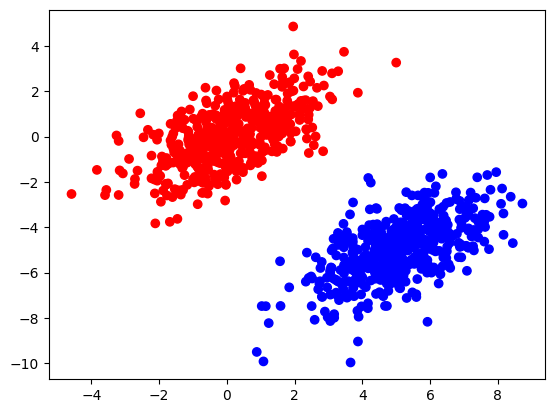

In [7]:
from helpers import plot_classification, get_separable

x, y, labels = get_separable()
plot_classification(x, y, labels)

Mamy dane pochodzące z dwóch klas, a nasze zadanie polega na implementacji klasyfikatora SVM czyli indukcji (w naszym dwuwymiarowym przypadku) linii która będzie separowała obie klasy. 
$$a \cdot x+b \cdot y +c = 0$$
Klasyfikator będzie przypisywał obiekt do jednej z klas gdy będzie się on znajdował po prawej stronie tej linii, jeśli zaś obiekt będzie po lewej jej stronie to przypiszemy obiekt do drugiej z klas. Znajdź taką linię dla powyższych danych, gdzie `x` i `y` to współrzędne punktów, a `labels` przyjmuje wartości $1$ i $-1$ wskazując na klasę obserwacji.

In [8]:
def construct_svm_opt_problem(x: np.ndarray, y: np.ndarray, labels: np.ndarray) -> Problem:
    """Funkcja budująca problem optymalizacji dla klasyfikatora SVM (hard margin).
    
    Args:
        x (np.ndarray): Współrzędne x obiektów
        y (np.ndarray): Współrzędne y obiektów
        labels (np.ndarray): Klasy obiektów
   
    Returns:
        Problem: Obiekt problemu optymalizacyjnego dla klasyfikatora SVM
   
    """

    a, b, c = Variable(), Variable(), Variable()
    objective = Minimize(a + b + c)
    constraints = []
    for xi,yi,label in zip(x,y,labels):
        constraints.append((a*xi + b*yi +c)*label >= 1)
    return Problem(objective, constraints)

prob = construct_svm_opt_problem(x, y, labels)
prob.solve()
prob.status

'optimal'

Jeśli dobrze wytrenowałeś klasyfikator to powinno się udać go narysować.

c:\Users\mikol\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3526: UserWarning: WARNING: plot_classification in helpers.py had a bug. SOLUTION: Modified plt.scatter to use x.ravel() and y.ravel() to match labels' shape.
  exec(code_obj, self.user_global_ns, self.user_ns)


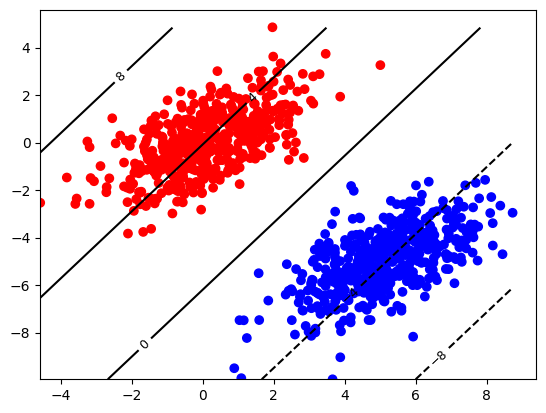

In [9]:
import warnings

a, b, c = prob.variables()
warnings.warn(
    "WARNING: plot_classification in helpers.py had a bug. "
    "SOLUTION: Modified plt.scatter to use x.ravel() and y.ravel() to match labels' shape.",
    stacklevel=2
)
plot_classification(x, y, labels, a=a.value, b=b.value, c=c.value)

Przejdźmy na trudniejszy zbiór, który nie jest liniowo separowalny. 

**UWAGA** Dane są losowane - istnieje mała szansa, że akurat wylosujesz zbiór separowalny. W takiej sytuacji powtórz wywołanie.

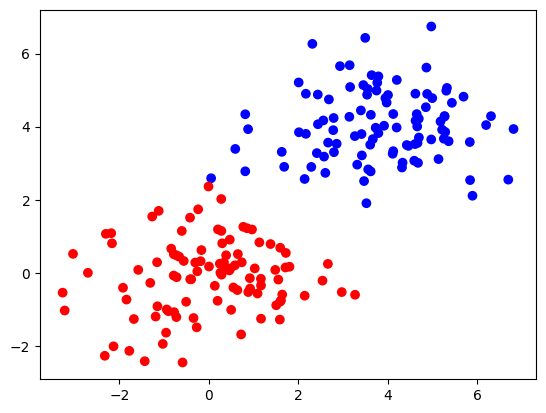

In [10]:
from helpers import plot_classification, get_non_separable

x, y, labels = get_non_separable()
plot_classification(x, y, labels)

Rozszerz swoją implementację klasyfikatora SVM tak aby prawidłowo działał również ze zbiorami nieliniowo separowalnymi. Za stałą $C$ możesz przyjąć 1.

In [11]:
def construct_softsvm_opt_problem(x: np.ndarray, y: np.ndarray, labels: np.ndarray, C: int = 1) -> Problem:
    """Funkcja budująca problem optymalizacji dla klasyfikatora SVM (soft margin).
    
    Args:
        x (np.ndarray): Współrzędne x obiektów
        y (np.ndarray): Współrzędne y obiektów
        labels (np.ndarray): Klasy obiektów
        C (int): Stała C
    
    Returns:
        Problem: Obiekt problemu optymalizacyjnego dla klasyfikatora SVM
    
    """

    a, b, c, eta = Variable(), Variable(), Variable(), Variable(len(labels))
    objective = Minimize(a + b + c + C*sum(eta))
    constraints = [eta >= 0]
    for xi,yi,label,etai in zip(x,y,labels,eta):
        constraints.append((a*xi + b*yi + c)*label >= 1-etai)
    return Problem(objective, constraints)

prob = construct_softsvm_opt_problem(x, y, labels)
prob.solve()
prob.status

'optimal'

Narysuj nauczony klasyfikator.

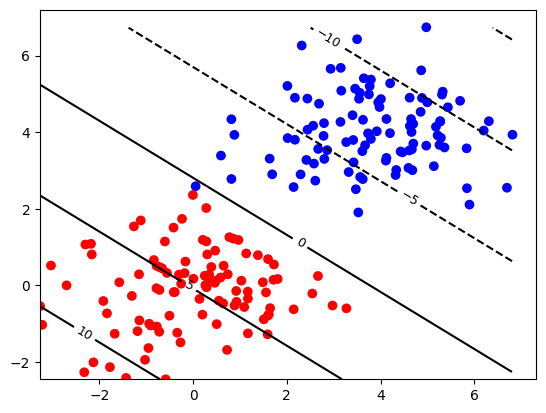

In [12]:
a, b, c, eta = prob.variables()
plot_classification(x, y, labels, a=a.value, b=b.value, c=c.value)

## Zadanie 2. - Eksploracja liniowego SVM (za 20%)

Wczytaj dane liniowo sepratowalne gdzie `X` to macierz cech, a `y` zwiera wartości klasy decyzyjnej.

In [13]:
from helpers import get_separable

x, y = get_separable(True)

Wytrenuj model maszyn wektorów podpierających używając obiektu SVC (Support Vector Classifier) z biblioteki `sklearn`. Konstruktor tego obiektu ma parametr `kernel` który domyślnie jest ustawiony na jądro RBF, początkowo będziemy chcieli używać wersji klasyfikatora bez jądra czyli inaczej z jądrem liniowym - ustaw ten parametr na wartość `"linear"`.

In [14]:
from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(x, y)

SVC(kernel='linear')

Kolejnym krokiem będzie narysowanie granicy decyzji. Funkcję możesz implementować przyrostowo, punkt po punkcie.
1. Niech funkcja narysuje dane uczące (x,y) zaznaczając kolorem klasy decyzyjne.
2. Zaznacz na wykresie granicę decyzji. Wytrenowany SVM (obiekt SVC) ma odpowiednie wartości nauczonych współczynników we właściwości `svm.coef_` a także wyraz wolny w `svm.intercept_`<br>
    *Wskazówka*: Zwróć uwagę, że linię separującą o wzorze
    $w_0*x_0 + w_1*x_1 + b = 0$ można przekształcić do postaci:
    $$x_1= -\frac{w_0}{w_1}  x_0 - \frac{b}{w_1} $$
3. Zaznacz na wykresie margines decyzji (np. poprzez narysowanie dwóch linii równoległych do granicy decyzji w odpowiedniej odległości). Przypomnij sobie, że z naszych wyprowadzeń wynika że wartość marginesu to $\frac{1}{||w||}$
4. Zakreśl specjalnym symbolem lub podświetl elementy zbioru uczącego będącymi wektorami podpierającymi. Ich współrzędne możesz odnaleźć we właściwości `svm.support_vectors_`

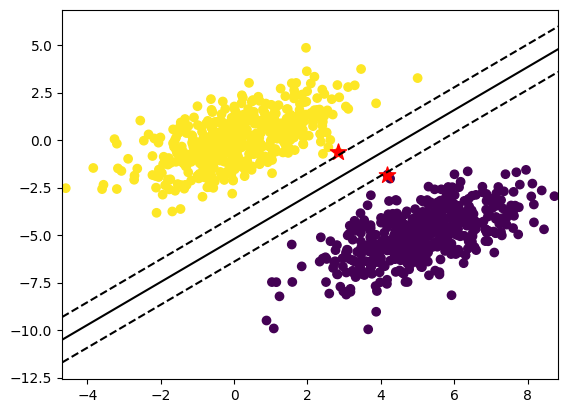

In [15]:
def plot_svm(svm: SVC, x: np.ndarray, y: np.ndarray) -> None:
    """Funkcja rysująca granicę decyzji klasyfikatora SVM.
    
    Args:
        svm (SVC): Wytrenowany klasyfikator SVM
        x (np.ndarray): Cechy
        y (np.ndarray): Klasy
    
    Returns:
        None
    """
    x0, x1 = x[:,0], x[:,1]
    plt.scatter(x=x0, y=x1, c=y)
    (A, B), C = svm.coef_[0], svm.intercept_[0]
    a, b = -A/B, -C/B
    
    xs = np.linspace(np.min(x0) - 0.1, np.max(x0) + 0.1, 100)
    ys = a*xs + b
    margin = 1/np.sqrt(A**2 + B**2)
    Cmax = C+margin
    Cmin = C-margin
    bmax = -Cmax/B
    bmin = -Cmin/B
    ysmax = a*xs + bmax
    ysmin = a*xs + bmin
    
    plt.plot(xs, ys, color='k')
    plt.plot(xs, ysmax, 'k--')
    plt.plot(xs, ysmin, 'k--')
    plt.scatter(*svm.support_vectors_.T, marker='*', color='red', s=150)
    plt.xlim(xs[[0, -1]])


plot_svm(model, x, y)

Zwróć uwagę na granicę decyzji, narysowany margines oraz podświetlone obiekty będące wektorami podpierającymi.

Wczytaj nowy zbiór danych

In [16]:
dane = np.load('data_outlier.npz')
x = dane['X']
y = dane['y'].reshape(-1)

oraz powtórz poprzednią procedurę tj. wytrenuj klasyfikator oraz narysuj wykres.

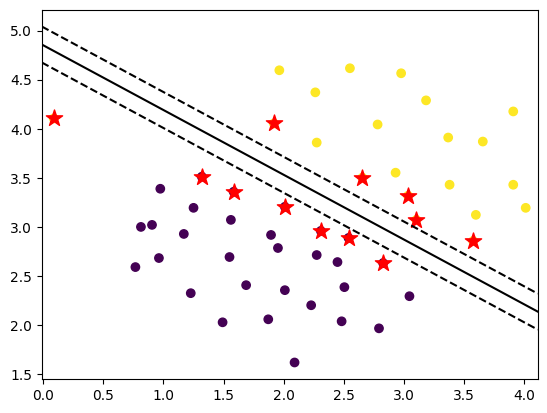

In [17]:
model = SVC(kernel='linear')
model.fit(x, y)
plot_svm(model, x, y)

W `sklearn` klasyfikator SVM ma domyślną wartość parametru $C = 1.0$. Zbiór jest jednak liniowo separowalny - sprawdź jak wygląda granica decyzji z innymi wartościami $C$ a w szczególności z wartością `C = float("inf")`. Wartość $C$ jest parametrem konstruktora obiektu SVC.

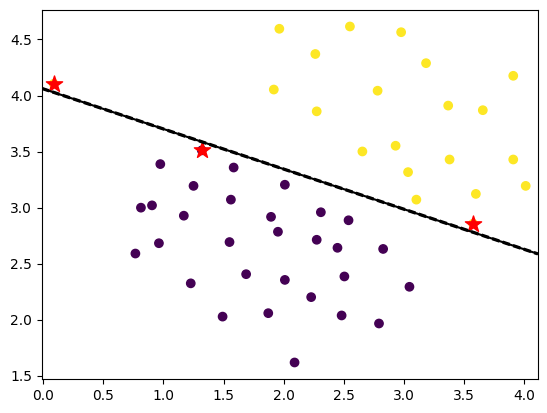

In [18]:
model = SVC(kernel='linear', C=1e10)
model.fit(x, y)
plot_svm(model, x, y)

Wypróbuj różne wartości parametru $C$ na zbiorze nieseparowalnym liniowo. 

In [19]:
from helpers import get_non_separable

x, y = get_non_separable(True)

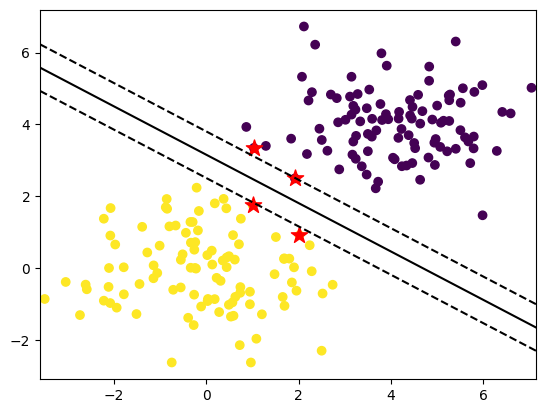

In [20]:
model = SVC(kernel='linear', C=1)
model.fit(x, y)
plot_svm(model, x, y)

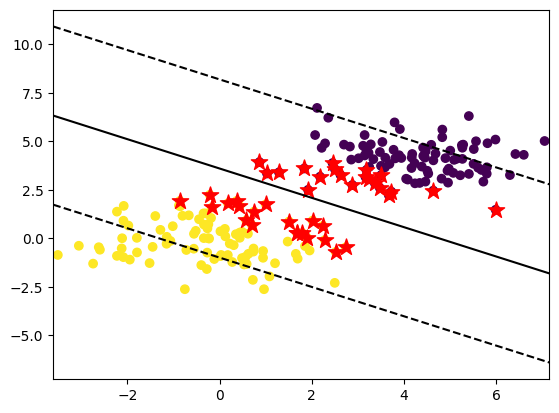

In [21]:
model = SVC(kernel='linear', C=1e-2)
model.fit(x, y)
plot_svm(model, x, y)

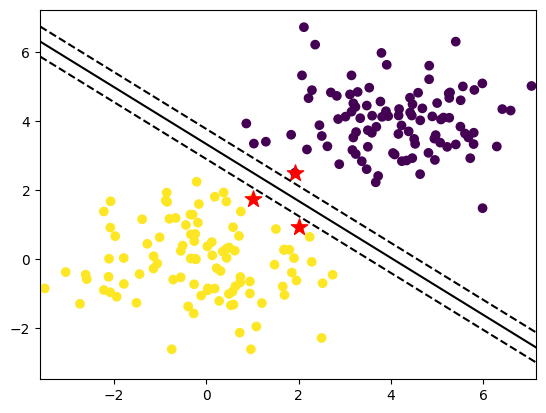

In [22]:
model = SVC(kernel='linear', C=1e6)
model.fit(x, y)
plot_svm(model, x, y)

**Polecenia**
1. Jak zmienia się wyindukowana granica decyzji dla bardzo dużych ($\infty$) i bardzo małych (np. 0.01) wartości $C$? Jak zmienia się trafność klasyfikatora na zbiorze uczącym? Jak sądzisz, która granica decyzja będzie najlepsza na zbiorze testowym?
2. Jak zmienia się liczba wektorów podpierających wraz ze zmianą $C$? Liczba wektorów podpierających jest miarą złożoności hipotezy - jakie wartości $C$ powodują bardziej złożone hipotezy? Odnieś te rozważania do przetargu wariancja - obciążenie.
3. Czy klasyfikator SVM jest klasyfikatorem który może zwrócić prawdopodobieństwo przynależności do klas? Czy jest to klasyfikator generatywny czy dyskryminacyjny?

Odpowiedz na powyższe pytania:

1. Dla bardzo dużych wartości $C$ granica decyzji dokładnie dopasowuje się do danych uczących, co może prowadzić do overfittingu. Outliery bardzo mocno wpływają na wynik końcowy (jak widzimy na przykładzie powyżej). SVM stara się żeby jak najwięcej przykładów uczących zostało sklasyfikowanych poprawnie, ale dzieje się to kosztem dokładności na danych ze zbioru testowego. Z kolei dla bardzo małych wartości $C$ granica się zwiększa i SVM zaczyna pozwalać na coraz więcej błędów. Najlepsza granica decyzji na zbiorze testowym to ta, która znajduje równowagę między dopasowaniem a generalizacją, czyli dla tych konkretnych danych na przykład $C \approx 1$.

2. Liczba wektorów podpierających rośnie, gdy wartość $C$ maleje, a maleje, gdy $C$ rośnie. Mniejsze $C$ prowadzi do klasyfikatora o większej wariancji, podczas gdy większe $C$ skutkuje klasyfikatorem o większym obciążeniu.

3. SVM standardowo nie zwraca prawdopodobieństw przynależności do klas. Jest to klasyfikator dyskryminacyjny, który koncentruje się na wyznaczeniu granicy rozdzielającej klasy, a nie na modelowaniu rozkładu prawdopodobieństwa w obrębie klas.


## Zadanie 3. - Trik jądrowy (za 20%)
Klasyfikator SVM, który jest liniowy jest dość mocno ograniczony. Nie będzie potrafił m.in. prawidłowo zaklasyfikować przedstawionego zbioru.

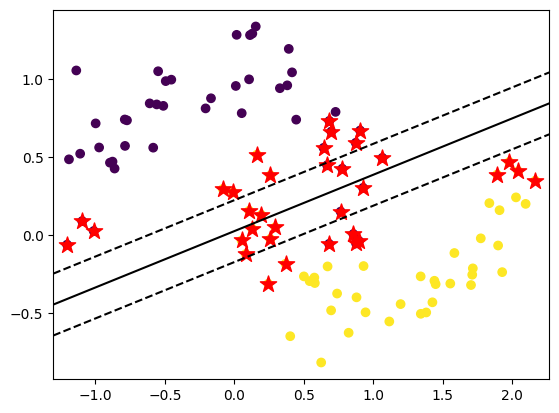

In [23]:
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, noise=0.15, random_state=2024)

model = SVC(kernel="linear")
model.fit(x, y)
plot_svm(model, x, y)

Problem ten można rozwiązać podobnie jak w przypadku regresji logistycznej: poprzez dodawanie dodatkowych cech. Na zajęciach z regresji dodawaliśmy cechy wielomianowe: spróbuj tego tricku również teraz wykorzystując obiekt `Pipeline` oraz `PolynomialFeatures` z cechami stopnia 3. 

**Uwaga**: do rysowania wykresu trzeba teraz użyć funkcji `plot_classifier`.

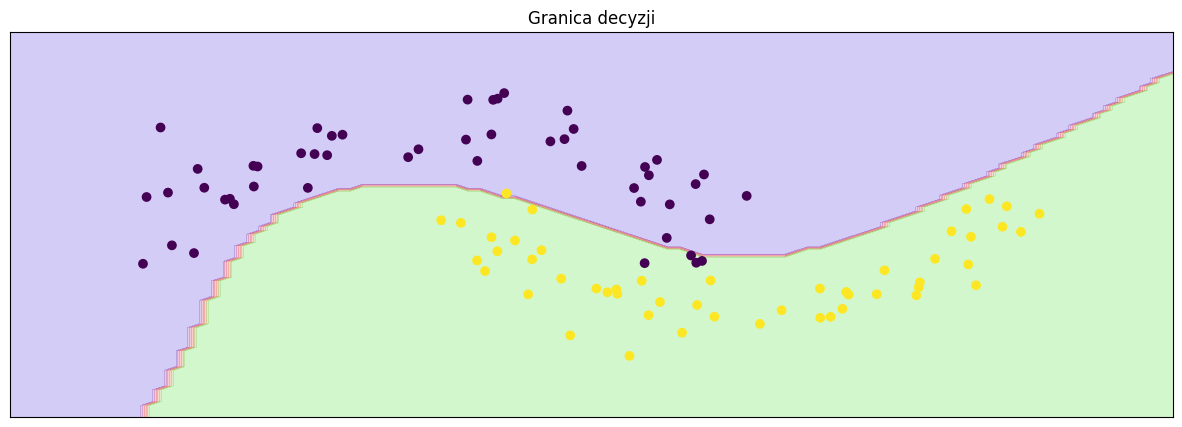

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from helpers import plot_classifier

pipeline = Pipeline([
    ('cubic features', PolynomialFeatures(degree=3, include_bias=False)),
    ('svc', SVC(kernel='linear'))
])

#call the pipeline
pipeline.fit(x, y)
plot_classifier(x, y, pipeline)

Tak jak dyskutowaliśmy na laboratoriach (i wykładzie) tego typu operacja dla zbiorów które mają nawet niezbyt dużo cech może wygenerować bardzo dużo cech. Dla przykładu rozważając zbiór z tysiącem cech i generację cech wielomianowych tylko *drugiego* rzędu (czyli de facto najniższego nieliniowego) spowoduje dodanie prawie pół miliona cech! Nie mniej jednak kernel (jądro) takiej operacji jest wyrażone wzorem:
$(x^Ty + 1 )^2$ i można je obliczyć w czasie liniowym od liczby oryginalnych cech (tutaj 1000)!

W obiekcie SVC możemy wykorzystać jądro wielomianowe specyfikując `kernel="poly"` oraz ew. podając dodatkowe parametry `degree` oraz `coef0`. Co oznaczają te parametry? Jądro wielomianowe jest wyrażone wzorem:
$$K(x,y) = (x^\mathsf{T} y + c)^{d}$$
gdzie $d$ to właśnie `degree`, a stała $c$ to `coef0`. Zmienna $d$ ma bardzo prostą interpretację: jest to stopień wielomianu. Stała $c$ ma natomiast szczególne znaczenie: jeśli jest ona równa $c=0$ to kernel generuje wszystkie jednomiany rzędu $d$ (jądro wielomianowe homogeniczne), jeżeli $c=1$ to kernel generuje wszystkie jednomiany rzędu co najwyżej $d$. Dodatkowo stała $c$ może być też strojona (ale w praktyce raczej rzadko się to robi)  ponieważ reguluje ona przetarg między wpływem cech wyższego rzędu a wpływem cech rzędu niższego. Stała $c$ nie może być ujemna. 

Wykorzystaj jądro wielomianowe do klasyfikacji badanego zbioru. (Pamiętaj o wyelimiowaniu dodawania cech wielomianowych!)

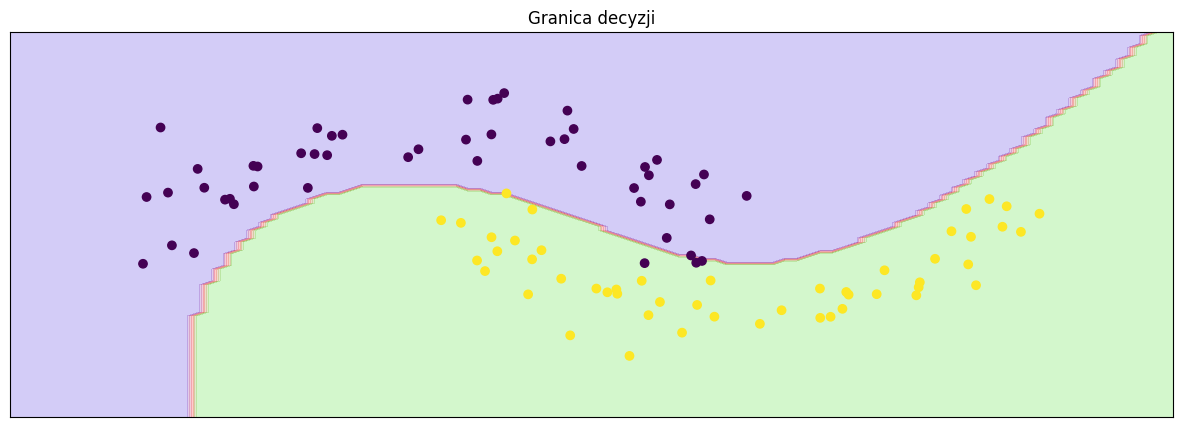

In [25]:
from helpers import plot_classifier

model = SVC(kernel='poly', coef0=1)
model.fit(x, y)
plot_classifier(x, y, model)

SVM z jądrami może sobie teraz poradzić także z problemem XOR. Wygenerujmy takie dane:

In [26]:
x = np.random.randn(200, 2)
y = np.logical_xor(x[:, 0] > 0, x[:, 1] > 0)

i wytrenuj klasyfikator. Spróbuj pozmieniać wartość kontrolującą złożoność hipotezy $C$ (nie jest to $c$ z funkcji jądra!).

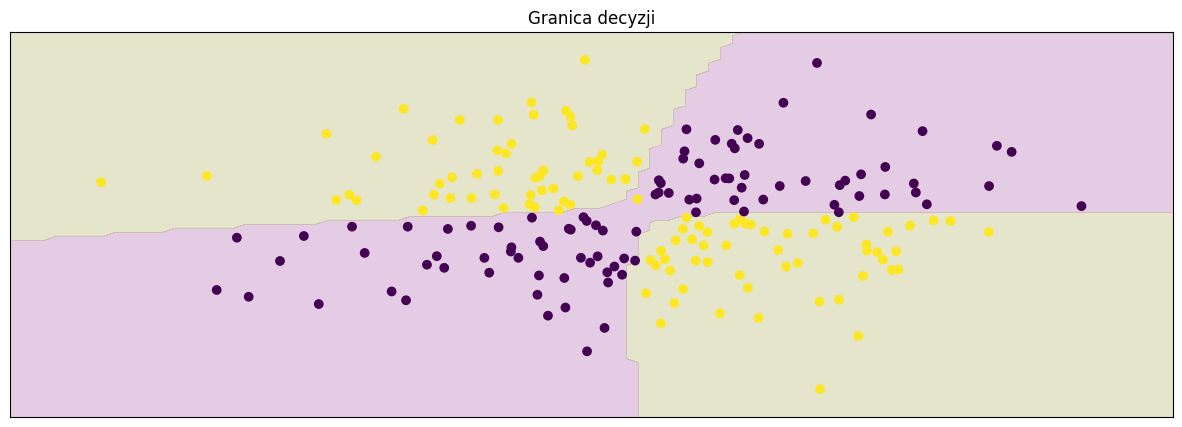

In [27]:
model = SVC(kernel='poly', coef0=1)
model.fit(x, y)
plot_classifier(x, y, model)

Posteruj parametrami `degree` i `C` dla problemu XOR oraz wcześniejszego problemu klasyfikacji (dwa księżyce).

Prawdopodobnie najczęściej stosowaną funkcją jądrową jest jądro RBF (*Radial basis function kernel*) wyrażone wzorem:
$${\displaystyle K(\mathbf {x} ,\mathbf {x'} )=\exp(-\gamma \|\mathbf {x} -\mathbf {x'} \|^{2})}$$
który inaczej zapisany ${\displaystyle K(\mathbf {x} ,\mathbf {x'} )=\exp \left(-{\frac {\|\mathbf {x} -\mathbf {x'} \|^{2}}{2\sigma ^{2}}}\right)}$ przypomina wzór na rozkład normalny (przy $\gamma^{-1} = 2\sigma ^{2}$). Jego działanie możemy sobie wyobrazić jako stosowanie rozkładu normalnego, który jest wycentrowany na rozważanym przykładzie $\mathbf{x}$ do mierzenia podobieństwa z innymi przykładami. Przypisuje on najwyższe "prawdopodobieństwo" (wartość funkcji jądrowej) do naszej obserwacji $\mathbf{x}$ a im dalej od niej tym wartość spada. Jeśli więc inny przykład $\mathbf{x'}$ leży blisko $\mathbf{x}$ w przestrzeni cech to jądro odpowie wysoką wartością, im dalej tym odpowiedź będzie niższa. Z kształtu rozkładu normalnego wiemy też, ze po przekroczeniu pewnej odległości ($3\sigma$) jądro będzie odpowiadało zawsze (prawie) zerem. Szybkość opadania funkcji jądra reguluje właśnie parametr $\sigma$: im jest on wyższy, tym wariancja (szerokość) rozkładu jest wyższa, więc jądro wolniej spada. Innymi słowy przykłady mają "większy zakres oddziałowywawania" na inne przykłady. W kontekście jądra RBF przyjęło się sterować parametrem $\gamma$, który jak już podawałem wynika z podstawienia:
$$\gamma = \frac{1}{2\sigma ^{2}}$$
czyli im wyższe $\gamma$ (niższe $\sigma$) tym mniejszy zakres oddziałowywania, funkcja szybciej spada z odległością od przykładu i na odwrót. 

Niezwykłą ciekawostką dot. tej funkcji jądrowej jest to, że gdybyśmy zastanowili się jak wygląda przestrzeń cech które powinniśmy wygenerować aby dostać taki wynik bez użycia triku jądrowego to okazałoby się, że jest ich... nieskończenie wiele!

Jak pewnie się domyślasz, zastąpienie w konstruktorze `SVC` wyboru jądra na `kernel="rbf"` oraz podanie parametru `gamma` umożliwi ci przetestowanie SVM z jądrem RBF. 

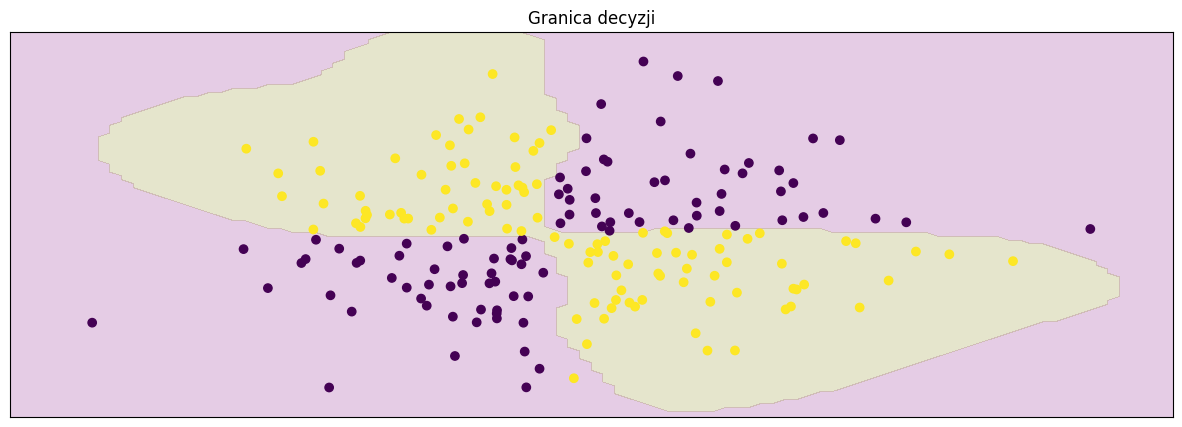

In [28]:
x = np.random.randn(200, 2)
y = np.logical_xor(x[:, 0] > 0, x[:, 1] > 0)


def plot_rbf(gamma: float) -> None:
    """Funkcja rysująca granicę decyzji klasyfikatora SVM z jądrem RBF.
    
    Args:
        gamma (float): Parametr gamma jądra RBF
        
    Returns:
        None
        
    """

    model = SVC(kernel='rbf', gamma=gamma)
    model.fit(x, y)
    plot_classifier(x, y, model)


plot_rbf(2)

**Polecenia**: 
1. Przetesuj kilka wartości `gamma`. Rozważ przynajmniej wartości 0.01, 0.1, 1, 10.
2. Jakie wartości `gamma` powodują przeuczenie, a jakie niedouczenie?
3. Wczytaj poprzedni problem z dwoma księżycami i spróbuj dobrać `gamma`.
4. Wygeneruj zbiór z szachownicą
    ```
    x = np.random.rand(2000,2)*20
    y = np.sin(x[:,0])+np.sin(x[:,1])>0
    ```
    i spróbuj wybrać odpowiednio sparametryzowaną funkcję jądrową.

5. Czy klasyfikator SVM jest odporny na zmianę skali? Innymi słowy czy powinno się normalizować cechy przed jego użyciem? Dlaczego?
6. Jak myślisz czy dla każdego problemu (lub ew. prawie każdego) jest możliwe takie dobranie jądra np. wielomianowego aby zbiór był liniowo separowalny? Tj. byłoby w tej przestrzeni możliwe nauczenie klasyfikatora SVM z $C=\infty$? (Możesz spróbować, ale nie musisz)
7. Klasyfikator SVM jest binarny. Jak mógłbyś go użyć do klasyfikacji danych wieloklasowych?

Odpowiedź na punkty 2., 5. i 7. wpisz poniżej (krótkie konkretne odowiedzi wystarczą), dla reszty pozostaw kod w komórkach i ich wyniki jako dowód Twoich eksperymentów.

2: Małe wartości C powodują niedouczenie: np. na tym zbiorze $C = 0.01$. Duże wartości C powodują przeuczenie: np. $C = 10$.

5: Klasyfikator SVM nie jest odporny na zmianę skali cech. Z tego powodu przed jego użyciem należy normalizować cechy, aby zapewnić, że wszystkie mają porównywalne zakresy i wpływ na model.

7: Klasyfikator SVM jest binarny, ale można go użyć do klasyfikacji wieloklasowej, stosując techniki takie jak "one-vs-one" (OvO) lub "one-vs-rest" (OvR), które tworzą kilka klasyfikatorów binarnych i łączą ich wyniki

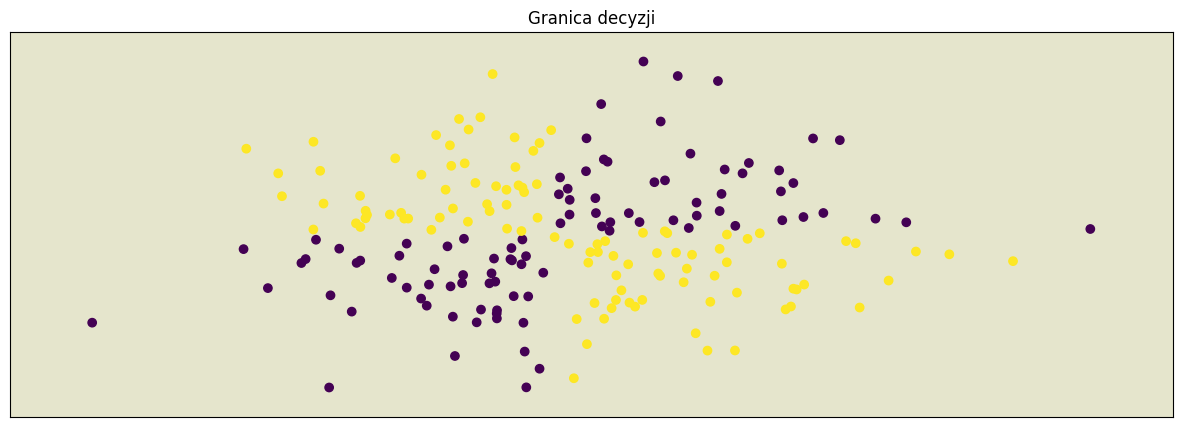

In [29]:
plot_rbf(0.01)

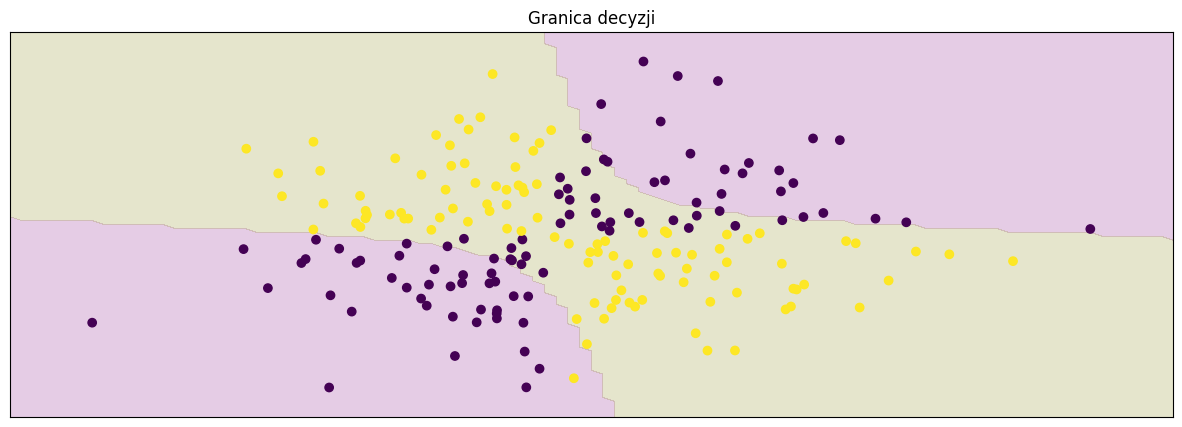

In [30]:
plot_rbf(0.1)

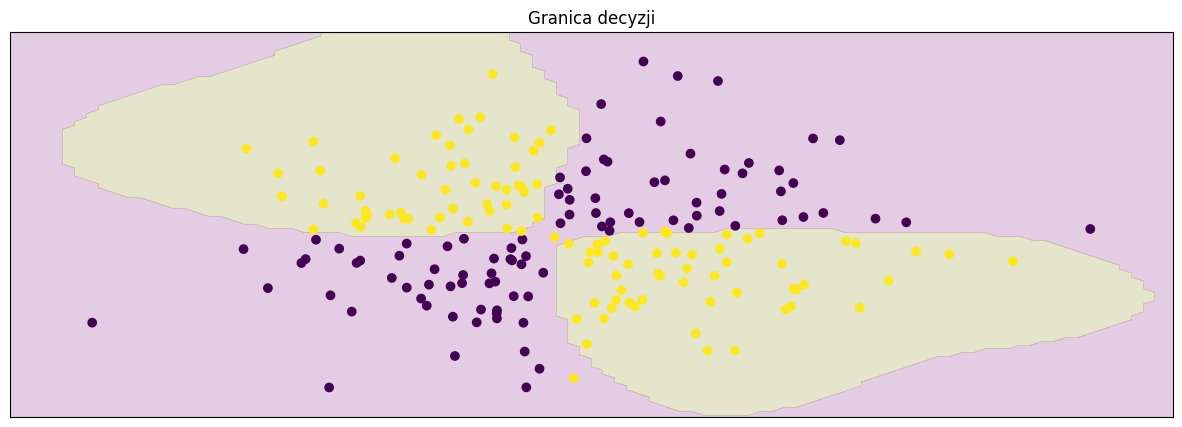

In [31]:
plot_rbf(1)

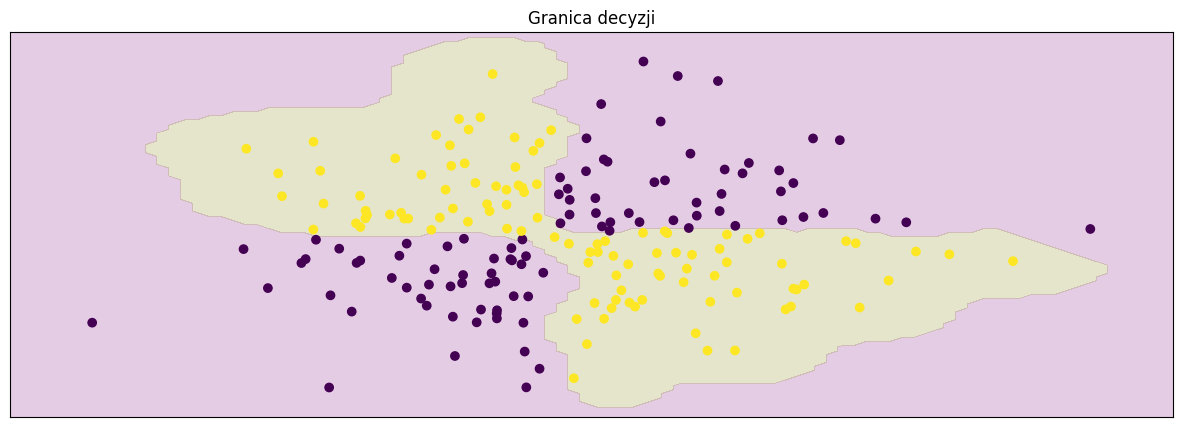

In [32]:
plot_rbf(10)

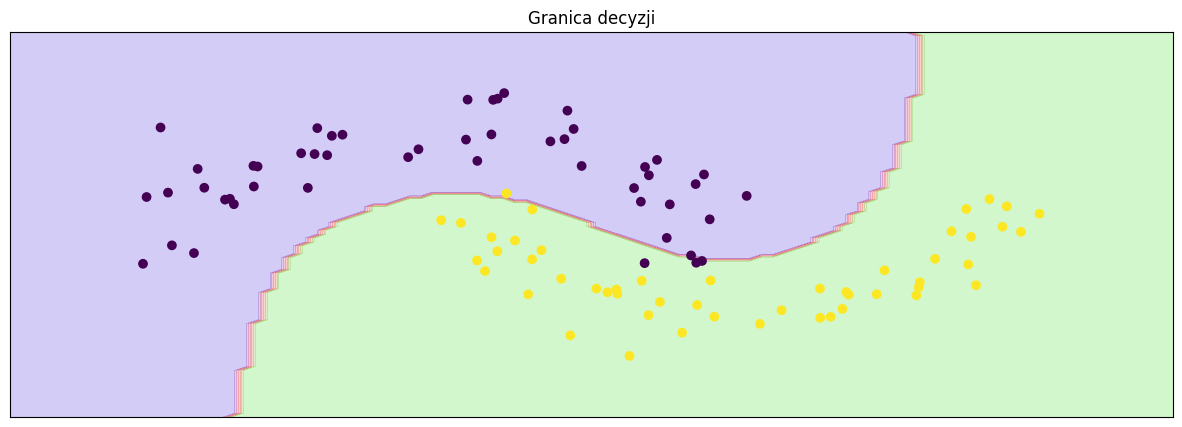

In [33]:
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, noise=0.15, random_state=2024)

plot_rbf(1)

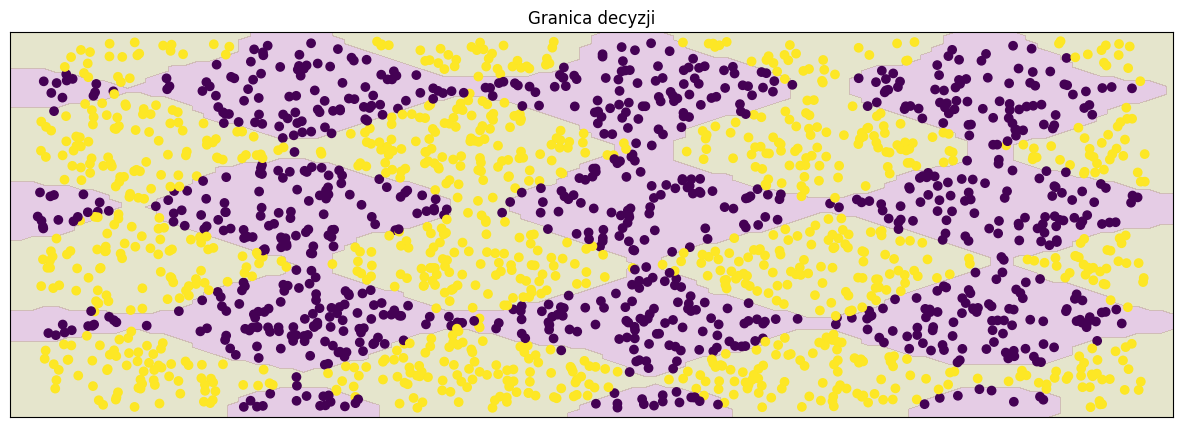

In [34]:
x = np.random.rand(2000,2)*20
y = np.sin(x[:,0])+np.sin(x[:,1])>0
plot_rbf(1)

## Zadanie 4. - Wybór parametrów (za 20%)

Wygeneruj dane z szachownicą (takie same jak w zadanich wyżej)

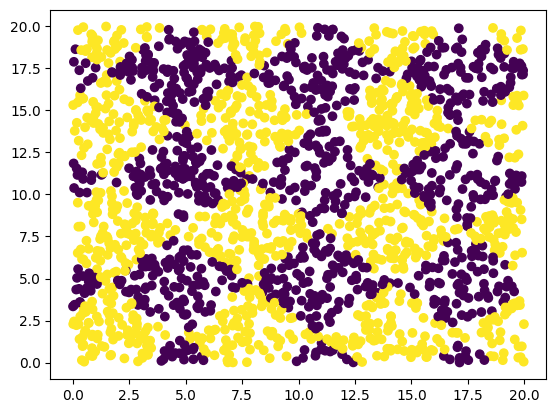

In [35]:
x = np.random.rand(2000, 2) * 20
y = np.sin(x[:, 0]) + np.sin(x[:, 1]) > 0
plt.scatter(x[:, 0], x[:, 1], c=y)

Spróbuj wybrać optymalne parametry dla klasyfikatora SVM z jądrem RBF (weź pod uwagę parametr `gamma` jądra i parametr `C`). Przykładową techniką poszukiwania dobrych parametrów jest zdefiniowanie tzw. siatki parametrów i sprawdzenie wszystkich możliwości. W pierwszym kroku musimy ustalić siatkę czyli np. dla parametru `gamma` będziemy testować wartości 0.1, 1, 10, a dla parametru `C` wartości 1 i 10. Poszukiwanie gridowe dla takiej siatki uruchomi proces uczenia 6 razy, zewaluuje trafność i zwróci najlepsze parametry. Ewaluacja trafności może się odbywać np. walidacją krzyżową, a w `sklearn` jest to zaimpementowane w obiekcie `GridSearchCV`.

Pierwszym argumentem konstruktora obiektu `GridSearchCV` jest obiekt klasyfikatora, a kolejne ważne parametry to ` param_grid= słownik z siatką`, `scoring='accuracy'` (aby była ewaluowana trafność). Dodatkowo można ustawić `verbose=2` jeśli chcesz, żeby pojawiły się na konsoli dodatkowe informacji o uczeniu kolejnych klasyfikatorów oraz parametrem `cv=` kontrulującym na ile cześci powinien zostać podzielony zbiór uczący w trakcie walidacji krzyżowej. Np.
```
GridSearchCV(KLASYFIKATOR, param_grid= PARAMETRY scoring='accuracy', verbose=2, cv=3)
```
Siatkę `PARAMETRY` definiujemy poprzez podanie słownika, którego kluczami są nazwy parametrów klasyfikatora, a wartościami są listy wartości do sprawdzenia np. `{'gamma':[0.1,1,10], 'C':[1,10]}`. `GridSearchCV` uruchamiamy standardowo czyli porzez funkcję `fit()`. 

Znajdź dobre ustawienia klasyfikatora SVM z jądrem RBF dla problemu z szachownicą.

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC(kernel='rbf')
params = dict(gamma=[0.1, 1, 10], C=[1, 10])
grid = GridSearchCV(model, param_grid=params, scoring='accuracy', cv=3, n_jobs=4)
grid.fit(x, y)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=4,
             param_grid={'C': [1, 10], 'gamma': [0.1, 1, 10]},
             scoring='accuracy')

Przyjrzyj się wynikowi - właściwość `GRID.best_params_`

In [37]:
grid.best_params_

{'C': 10, 'gamma': 1}

Oraz szczegółom przeszukiwania - właściwość `GRID.cv_results_`

In [38]:
grid.cv_results_

{'mean_fit_time': array([0.01435057, 0.01418201, 0.04363974, 0.01109862, 0.01117603,
        0.04354803]),
 'std_fit_time': array([0.00062456, 0.00023658, 0.0008525 , 0.00030817, 0.00023659,
        0.00040968]),
 'mean_score_time': array([0.0168461 , 0.01568151, 0.03303035, 0.01017435, 0.00951044,
        0.03253571]),
 'std_score_time': array([0.00047396, 0.00103066, 0.00071054, 0.00023445, 0.0004126 ,
        0.00040754]),
 'param_C': masked_array(data=[1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.1, 1, 10, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'gamma': 0.1},
  {'C': 1, 'gamma': 1},
  {'C': 1, 'gamma': 10},
  {'C': 10, 'gamma': 0.1},
  {'C': 10, 'gamma': 1},
  {'C': 10, 'gamma': 10}],
 'split0_test_score': array([0.88305847, 0.91454273, 0.90854573

Wytrenuj klasyfikator z najlepszymi znalezionymi parametrami i zwizualizuj go `plot_classifier`.

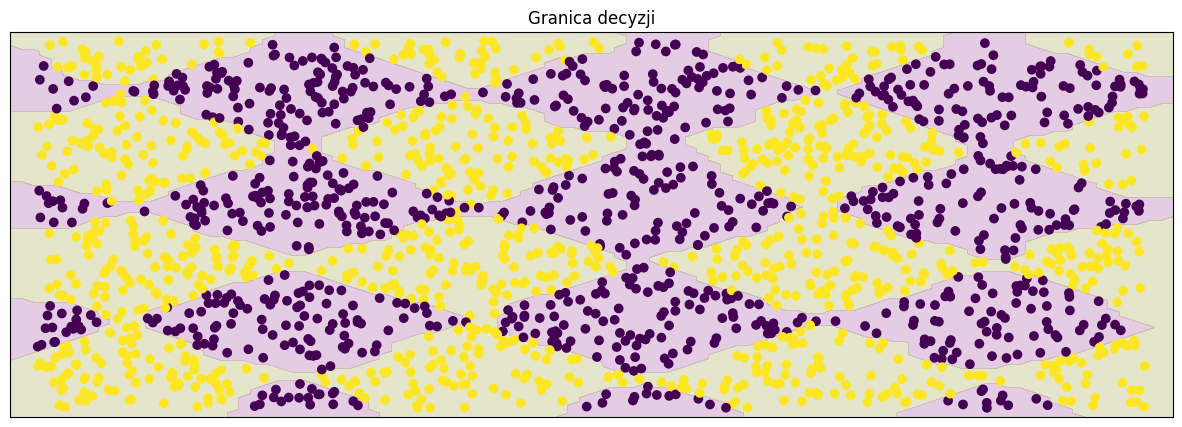

In [39]:
model = SVC(kernel='rbf', **grid.best_params_)
model.fit(x, y)
plot_classifier(x, y, model)

**Polecenia**
1. Typ funkcji jądrowej może być jednym z parametrów które stroimy. Jednak różne funkcje jądrowe mają różne parametry - jak to wyspecyfikować? Zobacz fragment [dokumentacji sekcja 3.2.1 ](https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search), który pokazuje jak to zrobić. Rozszerz twoje przeszukiwanie o jądra liniowe i wielomianowe.
2. Spróbuj strojenia na innym wybranym zbiorze.
3. Czy wynik uzyskany przez GridSearchCV jest dobrą estymacją trafności na zbiorze testowym?

Odpowiedź na punkt 3. poniżej.

3: Nie, przeszukiwanie gridowe wykonujemy na zbiorze treningowym i walidacyjnym, do których SVM może się nadmiernie dopasować, nawet podczas strojenia parametrów. Dopiero po procesie uczenia i strojenia parametrów należy sprawdzić trafność na zbiorze testowym. Oczywiście jeśli mamy odpowiednio dużo danych treningowych o rozkładzie zbliżonym do danych testowych, to trafność będzie wysoka, ale nie jest to bezpośrednio spowodowane GridSearchCV.

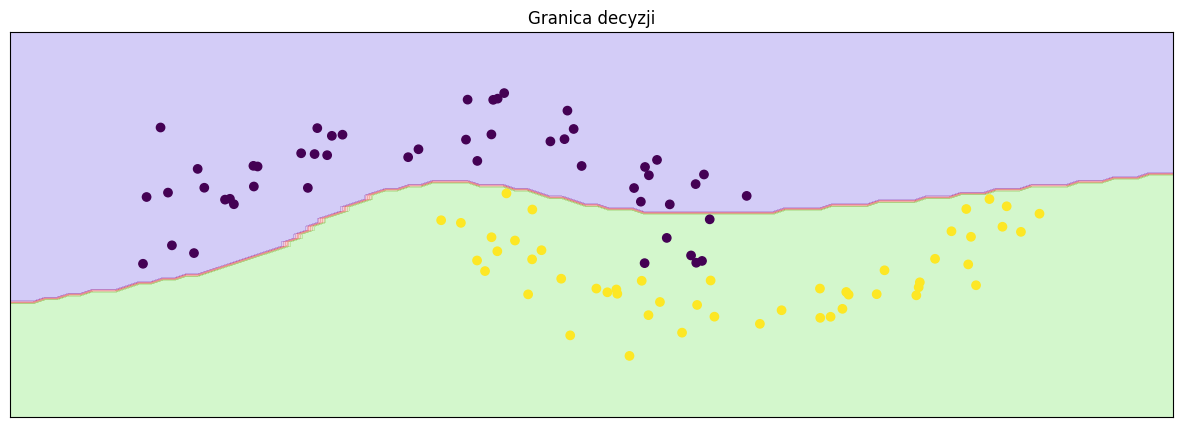

In [40]:
x, y = make_moons(n_samples=100, noise=0.15, random_state=2024)
params = [
    dict(gamma=[0.1,1,10], C=[1,10], kernel=['linear']),
    dict(gamma=[0.1,1,10], C=[1,10], kernel=['poly'], degree=[2,3]),
]
grid = GridSearchCV(SVC(), param_grid=params, scoring='accuracy', cv=3, n_jobs=4)
grid.fit(x, y)
model = SVC(**grid.best_params_)
model.fit(x, y)
plot_classifier(x, y, model)

## Zadanie 5. - SVM dla dużych danych (za 20%)

In [41]:
from helpers import get_wine

x, y = get_wine()

Metoda maszyn wektorów podpierających ma wiele zalet. Po pierwsze tworzy modele z dość małą liczbą wektorów podpierających które determinują wielkość nauczonego modelu. Dodatkowo faza predykcji jest bardzo szybka. Ponieważ uczenie jest zależne tylko od kilku, automatycznie wybieranych, wektorów podpierających, a resztę zbioru danych można by usunąć bez zmiany wyindukowanego klasyfikatora to wynik SVM zwykle zależy od małego podzbioru zbioru uczącego. SVM dobrze sobie radzą nawet w sytuacji gdy liczba przykładów jest dalece mniejsza niż liczba cech! (Przypomnij sobie co się wtedy dzieje z regresją liniową). Dodatkowo, pomimo tego że SVM jest klasyfikatorem liniowym to zastosowanie triku jądrowego pozwala na indukcje płaszczyzny separującej w rozszerzonej przestrzeni. Ponadto trik jądrowy pozwala na tworzenie własnych jąder dostosowanych do dziedziny problemu (tak jak w kNN mogliśmy projektować funkcje odległości) co spowodowało  szerokie ich wykorzystanie w tekstach czy obrazach (istnieją gotowe funkcje jądrowe nawet do przetwarzania grafów).

Jeśli chodzi o najważniejsze wady tego klasyfikatora to pierwszą dużą wadą jest konieczność strojenia parametrów funkcji jądrowych oraz parametru $C$. Jednakże w świetle powszechnego korzystania z sieci neuronowych, które wymagają strojenia znacznie większej liczby parametrów (architektura, różne dodatkowe triki) nie wiem czy nadal powinno się to uważać za  wadę nie do przeskoczenia. Druga wada SVM jest jednak znaczenie gorsza: koszt obliczeniowy uczenia. Rozwiązywanie problemu programowania kwadratowego definiowanego przez SVM jest rzędu sześciennego od liczby przykładów $\mathcal{O}[n^3]$ czy dla efektywniejszych implementacji $\mathcal{O}(\max(n,d) \min (n,d)^2)$  - nadal jest to bardzo kosztowne obliczeniowo.

Jednakże na ten drugi problem możemy rozwiązać za pomocą algorytmów w rodzaju stochastycznego spadku wzdłuż gradientu! Funkcja celu która jest optymalizowana przez SVM nazywamy funkcją zwiasową (*hinge loss*) i jest ona ekwiwalentna z prymalną postacią problemu. Jednak to właśnie jego postać dualna umożliwiała zastosowanie triku jądrowego. Aby więc zastosować SGD trzeba by rzeczywiście przeskalować zbiór uczący do przestrzeni cech definiowanej przez jądro (ona może mieć nawet $\infty$ liczbę wymiarów!). Na szczęście tak jak SGD używa przybliżonej estymacji gradientu tak samo możemy użyć *przybliżonej* transformacji jądrowej. Jedną z takich technik jest aproksymacja Nyströma, która wychodzi z założenia że macierz jądrowa jest rzędu $m$ dalece mniejszego od $n$. Zakłada się więc, że mając tylko wiedzę o $m$ wierszach macierzy jądrowej można zrekonstruować ją całą. W praktyce nie jest to prawda, ale po prostu mamy nadzieję, że $n-m$ najmniejszych wartości własnych jest na tyle małe że i tak uzyskujemy dobrą aproksymację (patrz: Materiały dla chętnych).

Wytrenuj na wczytanych danych SVM poprzez algorytm SGD - obiekt `SGDClassifier`. Pamiętaj o wyspecyfikowaniu zawiasowej funkcji straty `loss='hinge'`. Dodatkowo, aby wykonać trik jądrowy przetransformuj dane wejściowe aprokymacją Nyströma (obiekt `Nystroem`). Parametry tego obiektu to `kernel` (ustawmy RBF) oraz `gamma` (dla RBF), a także ` n_components` czyli ile wektorów używanych jest do przybliżenia jądra (domyślnie 100 i do naszych celów jest to wystarczające).

In [42]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2)
nyst = Nystroem(kernel='rbf', n_components=100)
x_tr_nyst = nyst.fit_transform(x_tr)
x_te_nyst = nyst.fit_transform(x_te)

Porównaj czas uczenia na tych samych danych modelu `SVC` oraz modelu przybliżonego (`Nystroem`+`SGD`). Czas wykonania komórki kodu możesz przetestować poprzez dodanie do niej na początku znacznika 
`%%timeit`.

In [43]:
%%timeit
model = SVC(kernel='rbf')
model.fit(x_tr, y_tr)

87.2 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%%timeit
model = SGDClassifier(loss='hinge')
model.fit(x_tr_nyst, y_tr)

14 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Polecenia**
1. Zwiększ rozmiar zbioru pięciokrotnie (kopiując przykłady). Jak teraz wygląda czas uczenia klasyfikatora obiema metodami?

In [45]:
x_large = np.tile(x, (5, 1))
y_large = np.tile(y, 5)
x_tr, x_te, y_tr, y_te = train_test_split(x_large, y_large, test_size=0.2)
nyst = Nystroem(kernel='rbf', n_components=100)
x_tr_nyst = nyst.fit_transform(x_tr)
x_te_nyst = nyst.fit_transform(x_te)

In [46]:
%%timeit
model = SVC(kernel='rbf')
model.fit(x_tr, y_tr)

4.41 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%%timeit
model = SGDClassifier(loss='hinge')
model.fit(x_tr_nyst, y_tr)

77.9 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


2. Porównaj trafności obydwu metod na zbiorze uczącym i testowym.

In [48]:
m1 = SVC(kernel='rbf')
m2 = SGDClassifier(loss='hinge')
m1.fit(x_tr, y_tr)
m2.fit(x_tr_nyst, y_tr)
print('SVC', np.mean(y_te == m1.predict(x_te)))
print('SGD', np.mean(y_te == m2.predict(x_te_nyst)))

SVC 0.9432045559488995
SGD 0.7212559642912113


3. Spróbuj przeskalować dane uczące przed użyciem obydwu metod np. metodą Min-Max
   ```
   from sklearn.preprocessing import MinMaxScaler
   scaler = MinMaxScaler()
   ```
   Jak zmienił się czas uczenia? Jak zmieniła się trafność modelu?

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_tr_scaled = scaler.fit_transform(x_tr)
x_te_scaled = scaler.fit_transform(x_te)
x_tr_nyst_scaled = scaler.fit_transform(x_tr_nyst)
x_te_nyst_scaled = scaler.fit_transform(x_te_nyst)

In [50]:
%%timeit
m1 = SVC(kernel='rbf')
m1.fit(x_tr_scaled, y_tr)

636 ms ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
m2 = SGDClassifier(loss='hinge')
m2.fit(x_tr_nyst_scaled, y_tr)

67.3 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
m1 = SVC(kernel='rbf')
m2 = SGDClassifier(loss='hinge')
m1.fit(x_tr_scaled, y_tr)
m2.fit(x_tr_nyst_scaled, y_tr)
print('SVC', np.mean(y_te == m1.predict(x_te_scaled)))
print('SGD', np.mean(y_te == m2.predict(x_te_nyst_scaled)))

SVC 0.9972294905340927
SGD 0.7360320147760505


4. Przetestuj różne wartości `n_components` transformacji przybliżonej. Spróbuj zaobserwować zależności pomiędzy trafnością modelu a modelem referencyjnym (bez przybliżenia). Możesz też spróbować porównać czasy uczenia dla kliku wielkości `n_components`.

In [53]:
import time

n_components_values = [50, 100, 200, 500, 1000]

for n_components in n_components_values:
    start_time = time.time()
    nyst = Nystroem(kernel='rbf', n_components=n_components)
    x_tr_nyst = nyst.fit_transform(x_tr)
    x_te_nyst = nyst.transform(x_te)
    sgd = SGDClassifier()
    sgd.fit(x_tr_nyst, y_tr)
    test_accuracy = sgd.score(x_te_nyst, y_te)
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Accuracy for n_components={n_components}: {test_accuracy:.2f}, Time: {elapsed_time:.4f} seconds")


Accuracy for n_components=50: 0.83, Time: 0.1071 seconds
Accuracy for n_components=100: 0.85, Time: 0.2420 seconds
Accuracy for n_components=200: 0.90, Time: 0.6703 seconds
Accuracy for n_components=500: 0.92, Time: 2.9902 seconds
Accuracy for n_components=1000: 0.94, Time: 5.1932 seconds
